# Chainer チュートリアル その１

https://qiita.com/mitmul/items/eccf4e0a84cb784ba84a
のなかから、学習の基本的な部分を実行してみる。



## 1. MNISTの準備


研究をするためには、本当は自分でデータを読み書きしたほうが良い。
自分で作ったニューラルネットのデバイスにデータを投入して、データをとるためである。
今回はChainarに集中するために、
ChanerにはMNISTを呼び出してくれる便利な関数があるので、それを使う。



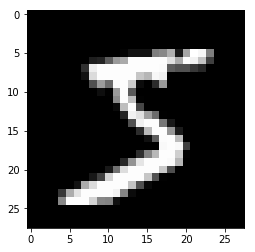

label: 5


In [1]:
from chainer.datasets import mnist

# データがダウンロードされていなければ、ダウンロードを行う
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# matplotlibがnotebookに反映されるようにする。
%matplotlib inline
import matplotlib.pyplot as plt

# データを例示する
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

trainとtestの配列の大きさを見てみよう。

In [2]:
print(len(train))
print(len(test))

60000
10000


# 2. Iteratorを作る 

データセットから一部のデータを取得し、それらを束ねてミニバッチを作成して学習を行おう。
学習はデータの投入、forwardの計算、重みの更新、の繰り返しで行うが、このループを抽象化したのがIteratorである。
Cainarではミニバッチに対して行う、学習やテストなどの繰り返しをIteratorをというオブジェクトで取り扱う。
この後の学習ループはIteratorを使用していく。

イテレータは、next()メソッドで新しいミニバッチを返す。内部ではデータセットを何周走査したか（epoch）、
現在のイテレーションが新しいepochの最初のイテレーションかどうかを管理するプロパティ（is_new_epoch）、
など、実験に必要な情報を保持する。

In [3]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

## Iteratorについて

Iterate:反復する


Iteratorは、配列に入っているデータの読み出しの管理をするオブジェクトである。

Chainerが用意しているSerialIteratorは、
データセットの中のデータを順番に取り出してくる最もシンプルなIteratorである。
データセットオブジェクトと、バッチサイズ指定すると、
データオブジェクトからランダムでバッチサイズの数だけデータを取り出し、
繰り返し読み出す準備をする。

渡したデータセットオブジェクトから、データを繰り返し読み出す必要がある場合はrepeat引数をTrueとし、
一巡したらそれ以上データを取り出したくない場合はこれをFalseとする。
デフォルトでは、True。

shuffle引数にTrueを渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更する。

batchsize = 128としているので、train_iterとtest_iterは、それぞれ128枚の数字画像データを読み出すためのIteratorということになる。

# 3. モデルの定義


ここでは、三層パーセプトロンを定義する。

ここで用いるMNISTデータセットは10種のラベルを持つため10とし、
中間層のユニット数は100とする。

Chainarでは、Link, Function, Chain、オブジェクトを用いて、ニューラルネットのモデルを記述していく。


## LinkとFunction
 
Linkとfunctionは、ニューラルネットの層を記述するためのオブジェクトである。

|          |Link           |Function         |
|----------|---------------|-----------------|
|パラメータ|持たない       |持つ             |
|モジュール| chainer.links |chainer.functions|

慣習的に以下のようにimportしておく.

`
import chainer.links as L
import chainer.functions as F
`

`L.Convolution2D()`や`F.relu()` などとして使う。

## Chain

Chainは、Linkを集めて、パラメータを持つ層を表現するクラスである。
学習の時には、Chainに入っているパラメータを更新していく。
Chainerで学習を行うときは、学習中にOptimizerが更新すべき全てのパラメータを簡単に取得できるように、Chainで一箇所にまとめておく。

また、モデルはChainクラスを継承したクラスとして定義されることが多い。
モデルを表すクラスのコンストラクタで、親クラスのコンストラクタにキーワード引数の形で登録したい層の名前と、オブジェクトを渡しておくと、自動的にOptimizerから見つけられる形で保持される。また、別の場所でadd_linkメソッドを使っても行うことができる。

関数呼び出しのようにしてモデルに()アクセサでデータを渡せるように、__call__メソッドを定義して、その中にforward処理を記述すると便利である。



## モデルの定義
実際のモデルの定義を示す。

1. ChainのサブクラスとしてMLPを定義している
2. 親クラスのコンストラクタに、層の名前を渡し、パラメータを持つオブジェクトを定義している。
3. `__call__`メソッドで、データを受け取ったときの計算を決めている

In [4]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # パラメータを持つ層の登録
        super(MLP, self).__init__(
            l1=L.Linear(None, n_mid_units),
            l2=L.Linear(n_mid_units, n_mid_units),
            l3=L.Linear(n_mid_units, n_out),
        )

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()


`L.Linear`は全結合層であり、引数は入力の数と出力の数である。これらが入力されると、パラメータが$入力\times 出力$だけ自動的に確保される。

`F.relu`はrelu関数で出力を評価し、出力値を変換する、という意味である。ステップ関数やシグモイド関数も用意されている。

'Linear'クラスは、Wとbのメンバ変数を持つ。Wはパラメータ行列、bはバイアスである。バイアスを見てみよう。

In [5]:
print('1つ目の全結合相のバイアスパラメータの形は、', model.l1.b.shape)
print('初期化直後のその値は、', model.l1.b.data)

1つ目の全結合相のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [6]:
print(model.l2.W)
print(model.l2.W.shape)

variable W([[-0.04102618  0.02721617 -0.12853308 ...,  0.08807396
             -0.08484822 -0.01528504]
            [-0.10545832  0.04503953 -0.14108773 ..., -0.06105508
              0.10733379  0.22184092]
            [ 0.03949065  0.00160416  0.10991538 ...,  0.02825215
             -0.01454245  0.0142852 ]
            ..., 
            [-0.0999627   0.07811061 -0.04531647 ...,  0.24858736
             -0.0011903  -0.0678406 ]
            [-0.03981388  0.01258735 -0.12455377 ...,  0.12476893
              0.0600693   0.20158371]
            [ 0.02554563  0.0544226   0.09823129 ...,  0.04297119
              0.09561111  0.01461734]])
(100, 100)


## 学習

学習のステップは以下のようになる。

1. 予測値の計算
1. 損失関数の計算
1. 重みの更新
1. 適切なところで途中結果を表示

まず、現在の重みでMLPに分類を行わせる。
その結果は、入力された画像がどのクラスに分類されるか？という
10個のニューロンからの出力である。

次に、損失関数の計算を行う。得られた出力が合っているか誤っているかを
判断する値を実数で算出する。

最後に、重みを更新する。得られた出力が誤っている場合、重みを正しい方向に
修正する必要がある。重みを修正するアルゴリズムは最適化手法といい、
chainer.optimizersモジュール以下から選択できる。

ここでは、最適化手法として勾配降下法の手法であるoptimizers.SGDを用いる。
Optimizerのオブジェクトには、setupメソッドを使ってChainオブジェクトを渡す。
こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的に検出する。

最適化手法は他に、MomentumSGD, RMSprop, Adamがある。`chainer.optimizers.SGD`の部分を`chainer.optimizers.最適化手法名`と変更することで手軽に試せるので、色々と試してみて結果の変化を見てみるとよい。

from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)


In [7]:
from chainer import optimizers
optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model) 

In [8]:
import numpy as np
from chainer.dataset import concat_examples

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, -1)

    # 予測値の計算
    y = model(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    model.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(loss.data)), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            x_test, t_test = concat_examples(test_batch, -1)

            # テストデータをforward
            y_test = model(x_test)

            # ロスを計算
            loss_test = F.softmax_cross_entropy(y_test, t_test)
            test_losses.append(loss_test.data)

            # 精度を計算
            accuracy = F.accuracy(y_test, t_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.7337 val_loss:0.7289 val_accuracy:0.8339
epoch:02 train_loss:0.4378 val_loss:0.4538 val_accuracy:0.8803
epoch:03 train_loss:0.2786 val_loss:0.3752 val_accuracy:0.8973
epoch:04 train_loss:0.3122 val_loss:0.3368 val_accuracy:0.9053
epoch:05 train_loss:0.3565 val_loss:0.3117 val_accuracy:0.9108
epoch:06 train_loss:0.3596 val_loss:0.2959 val_accuracy:0.9160
epoch:07 train_loss:0.2818 val_loss:0.2817 val_accuracy:0.9198
epoch:08 train_loss:0.2877 val_loss:0.2713 val_accuracy:0.9237
epoch:09 train_loss:0.3340 val_loss:0.2609 val_accuracy:0.9254
epoch:10 train_loss:0.2545 val_loss:0.2516 val_accuracy:0.9291


val_accuracyをみると、0.93近くの値になっている。シンプルな3層ネットワークでも、93%の認識率が出ているようだ。

# 4. 学習したモデルを使う

学習を行ったら、そのモデルを保存しておき、実際に分類を行うときに
保存したモデルを読み込んで使用する。

## モデルの保存
モデルを保存するための形式はHDF5とNumpyのNPZが選べる。HDF5形式のほうが汎用性があるが、今回は簡単のため追加ライブラリの不要なNPZで保存しよう。

In [9]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# ちゃんと保存されていることを確認
%ls -la my_mnist.model

-rw-rw-r-- 1 aslguest aslguest 333915 10月  3 11:37 my_mnist.model


## モデルの読み込みと使用

上で保存したNPZファイルを読み込んで、テストデータに対するラベルの予測を行ってみる。
保存したNPZファイルにはMLPモデルのパラメータが記録されているので、
まずはモデルのオブジェクトを生成し、そのなかにNPZが持っている値を書き込むことで、
読み出しを実現する。


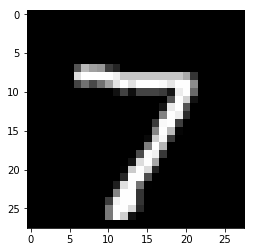

label: 7


In [10]:
# まず同じモデルのオブジェクトを作る
infer_model = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_model)

# テストデータ
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

これで、学習->保存->推論ができた。
時間のかかる学習も一度やっておけば、モデルの保存と読み出しを行うことで、推論をすることができる。

## GPUの利用

学習時間を短縮するために、GPUを利用しよう。

GPUはPCとPCI Expressインターフェイスで接続されていて、CPUとは異なるメモリをつかう。
GPUに計算をさせるためには、CPUとGPUのデータのやりとりを少し書かなければならない。

モデルはChainのサブクラスで定義したクラスであった。この、モデルをGPUで実行させるために、インスタンスに`to_gpu()`メソッドで
GPUで実行させるための指示をする。GPUは0から始まるidで管理されている。`to_gpu()`メソッドを呼び出すときに、GPUのIDを渡す。

In [11]:
gpu_id=0
gpu_model = MLP()
gpu_model.to_gpu(gpu_id)

次に、乱数の生成系列の固定を行う。この操作は必須ではないが、実行するたびに異なる結果が出力されることを防ぐ効果があり、実験をする場合には便利である。

In [12]:
import numpy
numpy.random.seed(0)
import chainer
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(0)

次に、optimizerの設定と、訓練ループを示す。optimizerの設定は変更がないが、訓練ループでは、結果の表示にGPUからCPUへデータを転送するための関数`to_cpu()`を使っていることに気をつけること。

In [13]:
from chainer.cuda import to_cpu
import chainer.links as L
import chainer.functions as F

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

gpu_opt = optimizers.SGD(lr=0.01)
gpu_opt.setup(gpu_model)

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)  # GPUに訓練データを転送する

    # 予測値の計算
    y = gpu_model(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    
    # 勾配の計算
    gpu_model.cleargrads()
    loss.backward()

    # パラメータの更新
    gpu_opt.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='') # loss.dataはGPUからCPUへ転送されている

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            x_test, t_test = concat_examples(test_batch, gpu_id) #テストデータをGPUに転送する

            # テストデータをforward
            y_test = gpu_model(x_test)

            # ロスを計算
            loss_test = F.softmax_cross_entropy(y_test, t_test)
            test_losses.append(to_cpu(loss_test.data)) # loss.dataはGPUからCPUへ転送されている

            # 精度を計算
            accuracy = F.accuracy(y_test, t_test)
            accuracy.to_cpu() # accuracyはGPUからCPUに転送されている
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies))) 

epoch:01 train_loss:0.7327 val_loss:0.7453 val_accuracy:0.8357
epoch:02 train_loss:0.3664 val_loss:0.4452 val_accuracy:0.8822
epoch:03 train_loss:0.4008 val_loss:0.3721 val_accuracy:0.8985
epoch:04 train_loss:0.3041 val_loss:0.3315 val_accuracy:0.9090
epoch:05 train_loss:0.2769 val_loss:0.3088 val_accuracy:0.9124
epoch:06 train_loss:0.2982 val_loss:0.2934 val_accuracy:0.9157
epoch:07 train_loss:0.2013 val_loss:0.2802 val_accuracy:0.9190
epoch:08 train_loss:0.2289 val_loss:0.2682 val_accuracy:0.9226
epoch:09 train_loss:0.3878 val_loss:0.2589 val_accuracy:0.9243
epoch:10 train_loss:0.2515 val_loss:0.2497 val_accuracy:0.9269


GPUでの実行を最適化していないので速度向上は少なかったが、結果を得ることができた。

# まとめ

ここではChainarの練習として、MNISTデータを読み込んで、3層のニューラルネットで学習を行った。
また、学習したパラメータ（重み）の保存と読み込み、GPU上での実行も行った。